## Notebook Description
### Model Three
This notebook is dedicated to my third model, which uses data from `engineered_data` folder. The model runs the `title_merge` column through the `CountVectorize`, then using a `FeatureUnion` joins the Feature Engineered columns before running the entire dataframe through a `Logistic Regression` model. Resulting in an Accuracy Score of 0.933. This is my best model and used in the presentation.

In [93]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import FunctionTransformer

In [94]:
df = pd.read_csv('../engineered_data/engineered_data_merged_columns.csv')

In [95]:
df.head()

,subreddit,created_utc,title_merge,title_sentiment_neg,title_sentiment_neu,title_sentiment_pos,title_sentiment_compound,title_length,title_word_count,capitalized_letters_in_title,sentences_in_title
0,backpacking,1646011972,"Where to backpack 4 nights in Utah, Arizona, o...",0.000,0.804,0.196,0.9127,315,60,16,4
1,backpacking,1646007041,"Peace Walls, Belfast",0.000,0.364,0.636,0.5423,21,4,3,0
2,backpacking,1646005307,How To Mount Snowshoes On Osprey Talon 22 Back...,0.000,0.760,0.240,0.9282,247,45,11,5
3,backpacking,1646004876,Bringing dog to Kearsarge pass? [removed],0.000,1.000,0.000,0.0000,41,6,2,1
4,backpacking,1646000495,Mid 30s short trip to Thailand - Bangkok &amp;...,0.024,0.787,0.189,0.9786,839,162,32,11


#### Baseline Model

In [96]:
# Baseline model
# Need my model to be better than .50

df['subreddit'].value_counts(normalize=True)

ultrarunning    0.500125
backpacking     0.499875
Name: subreddit, dtype: float64

#### Set Up Target Variable

In [97]:
df['subreddit'] = df['subreddit'].replace({'ultrarunning': 0, 'backpacking': 1})

In [98]:
# Create X and Y for Log_Reg

X = df.drop(columns=['subreddit'])
y = df['subreddit']

In [99]:
# Train/Test/Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Using Feature Union to utilize Feature Engineered columns in Pipeline

The following steps allow for `CountVectorizing` the `title_merge` column, while also passing in the feature engineered columns to the `Logistic Regression` model. Ultimately, a nested pipeline allows for this. Indexing into this nested relationship to tune hyperparameters can be seen with strings such as `feats__vect_pipe__vect__binary` in the `params_grid` dictionary

In [100]:
def get_title(df):
    return df['title_merge']

get_title_transformer = FunctionTransformer(get_title, validate=False)

In [101]:
def get_other_columns(df):
    return df[['title_sentiment_compound', 'title_length', 'title_word_count',
           'capitalized_letters_in_title', 'sentences_in_title']]

get_columns_transformer = FunctionTransformer(get_other_columns, validate=False)

In [102]:
pipe_cv = Pipeline([
    ('title_transform', get_title_transformer),
    ('vect', CountVectorizer())
])

In [103]:
pipe_model = Pipeline([
    ('feats', FeatureUnion([
        ('vect_pipe', pipe_cv),
        ('other_cols', get_columns_transformer)
    ])),
    ('log_reg', LogisticRegression())
])

In [104]:
param_grid = {
    'feats__vect_pipe__vect__binary': [True, False],
     'log_reg__max_iter': [1500]
}
gs = GridSearchCV(pipe_model,
                  param_grid=param_grid,
                  verbose=1,
                  scoring='accuracy'
                 )
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.9316410684474123


{'feats__vect_pipe__vect__binary': True, 'log_reg__max_iter': 1500}

### Evaluations

In [105]:
gs.score(X_train, y_train)

0.9933311103701233

In [106]:
gs.score(X_test, y_test)

0.933

#### Predictions

In [107]:
preds = gs.predict(X_test)
preds[:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

#### Model Evaluation

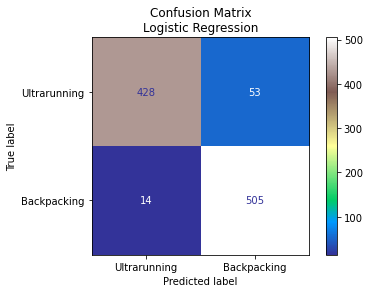

In [108]:
plot_confusion_matrix(gs, X_test, y_test, cmap='terrain', display_labels=['Ultrarunning', 'Backpacking'])
plt.title('Confusion Matrix\nLogistic Regression', fontdict = {'fontsize':12})
plt.savefig("../graphics/model_three_lr_confusion_matrix.jpg", bbox_inches="tight", dpi=100); #save as jpg

In [109]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

print(f'TN = {tn}')
print(f'FP = {fp}')
print(f'FN = {fn}')
print(f'TP = {tp}')

TN = 428
FP = 53
FN = 14
TP = 505


In [110]:
metrics.accuracy_score(y_test, preds)

0.933

In [111]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       481
           1       0.91      0.97      0.94       519

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.94      0.93      0.93      1000



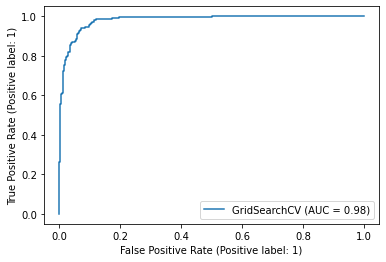

In [112]:
plot_roc_curve(gs, X_test, y_test)
plt.savefig("../graphics/model_three_lr_roc_curve.jpg", bbox_inches="tight", dpi=100); #save as jpg

### Coefficients
Interpreted as, for each instance of the word "backpacking" it's 10.9x more likely to be your positive class (backpacking) vs your negative class (ultrarunning)

In [113]:
coef = gs.best_estimator_.named_steps['log_reg'].coef_ # get coefficients
features = gs.best_estimator_.named_steps['feats'].transformer_list[0][1].named_steps['vect'].get_feature_names() #get feature names
zipped = zip(coef[0], features) #zip them together
lst = list(zipped) #turn zip object into a list
coef_df = pd.DataFrame(lst) # turn list into a df
coef_df[0] = np.exp(coef_df[0]) # because logistic regression puts the coefficients on a log scale, you have to do this.

In [114]:
coef_df.sort_values(by = 0, ascending=False)

,0,1
2156,11.056749,backpacking
13635,5.594199,travel
6707,5.215689,hike
13721,4.850473,trip
2151,3.981651,backpack
...,...,...
13592,0.116115,training
11405,0.086697,run
13866,0.080508,ultra
10661,0.080120,race


In [115]:
top_ten_pos_class = coef_df.sort_values(by=0, ascending=True).tail(10)
top_ten_pos_class

,0,1
2064,2.412581,australia
2961,2.847478,camp
7152,2.858506,india
11031,3.263461,removed
6712,3.448559,hiking
2151,3.981651,backpack
13721,4.850473,trip
6707,5.215689,hike
13635,5.594199,travel
2156,11.056749,backpacking


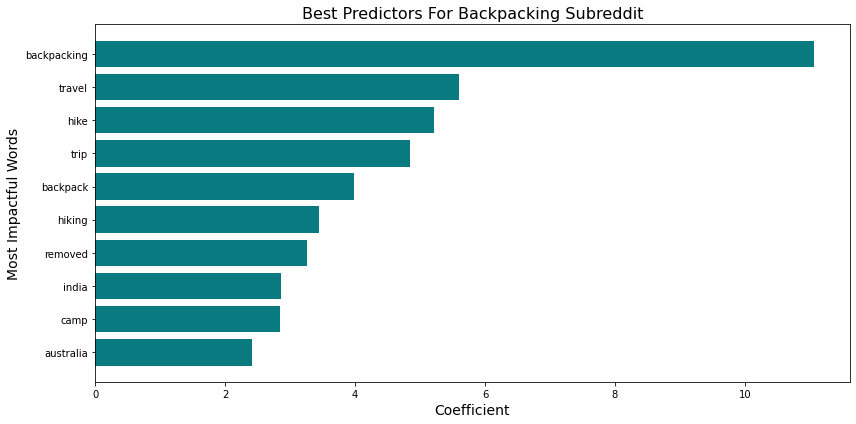

In [116]:
plt.figure(figsize=(12,6))
best_pred_sust = top_ten_pos_class.sort_values(by=0, ascending=False).head(15)
best_pred_sust = top_ten_pos_class.sort_values(by=0, ascending=True).tail(15)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color = '#097a80')
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.ylabel('Most Impactful Words', fontdict= {'fontsize':14})
plt.title('Best Predictors For Backpacking Subreddit', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig("../graphics/model_three_lr_Top10_backpacking_coef.jpg", bbox_inches="tight", dpi=100); #save as jpg;

In [117]:
top_ten_neg_class = coef_df.sort_values(by=0, ascending=False).tail(10)
top_ten_neg_class

,0,1
47,0.200765,100
13888,0.198135,ultras
13886,0.188397,ultrarunning
895,0.187081,50k
11414,0.147891,runners
13592,0.116115,training
11405,0.086697,run
13866,0.080508,ultra
10661,0.080120,race
11418,0.042326,running


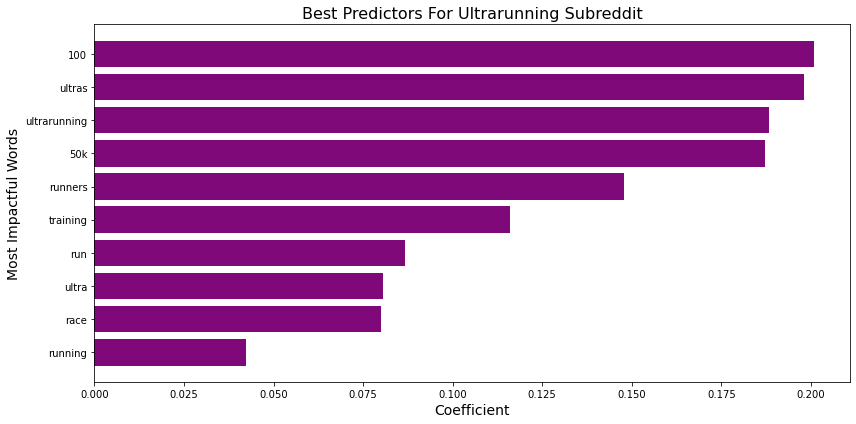

In [118]:
plt.figure(figsize=(12,6))
best_pred_sust = top_ten_neg_class.sort_values(by=0, ascending=False).head(15)
best_pred_sust = top_ten_neg_class.sort_values(by=0, ascending=True).tail(15)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color = '#80097a')
plt.xlabel('Coefficient', fontdict= {'fontsize':14})
plt.ylabel('Most Impactful Words', fontdict= {'fontsize':14})
plt.title('Best Predictors For Ultrarunning Subreddit', fontdict = {'fontsize':16})
plt.tight_layout()
plt.savefig("../graphics/model_three_lr_Top10_ultrarunning_coef.jpg", bbox_inches="tight", dpi=100); #save as jpg;

### Analyzing Misclassified Predictions

In [119]:
misclassified = X_test[y_test != preds]

misclass_subreddit = pd.merge(misclassified, df['subreddit'], left_index=True, right_index=True)

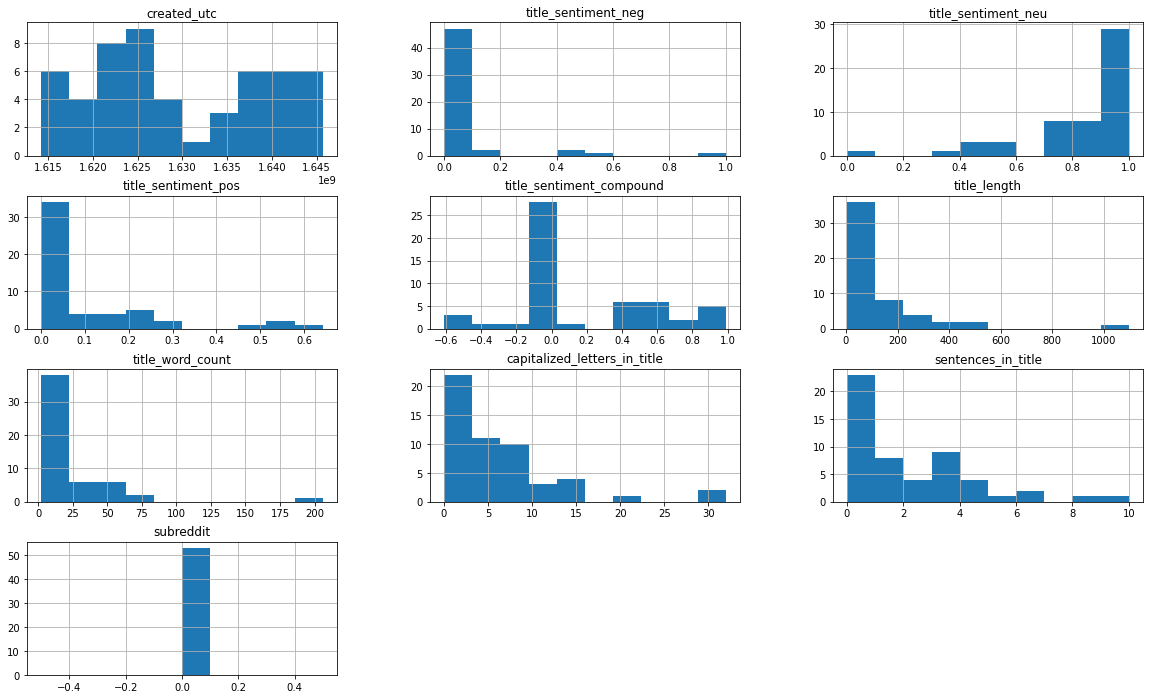

In [120]:
# Looking at the distribution of posts by feature from the Ultrarunning subreddit that were misclassified

ultrarunning_misclassified = misclass_subreddit[misclass_subreddit['subreddit'] == 0]
ultrarunning_misclassified.hist(figsize=(20,12));

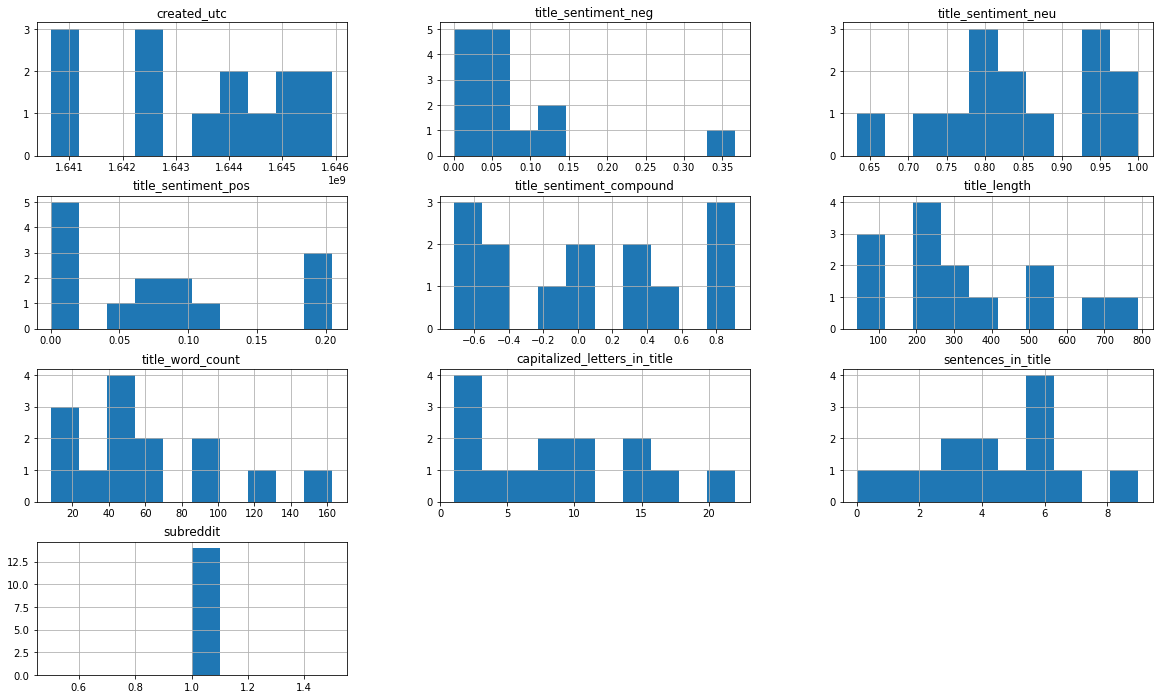

In [121]:
# Looking at the distribution of posts by feature from the Backpacking subreddit that were misclassified

backpacking_misclassified = misclass_subreddit[misclass_subreddit['subreddit'] == 1]
backpacking_misclassified.hist(figsize=(20,12));

In [122]:
pd.set_option('display.max_rows', 500)
backpacking_misclassified_subset = backpacking_misclassified[['title_merge']].loc[[1178, 729, 298, 283]]
backpacking_misclassified_subset[['title_merge']].style.set_properties(subset=['title_merge'], **{'width': '600px'})

,title_merge
1178,My lighting kit for all overnight trips. What do you all bring and why?
729,"What kind of pillow do you use, and what other types have you tried? What kind of pillow do you usually use lately, and what types of you used in the past? What didn't you like about those that you like about your current pillow? Thanks"
298,Who else has tried this insane incline??
283,"recs for filtering bottles like nalgene's everyday type, but no straw? Or that don't use a soft straw if they do use a straw? mainly need to filter tap, have a multi year warranty / high durability like Grayl's 10yr, and bonus if lighter than stainless steel."
